# Capstone 1: Implementasi ETL

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

import requests
import json

## Unduh data dari source

Data diunduh dengan menggunakan API Kaggle. Jalankan command berikut di dalam folder `data`. Apabila folder tersebut belum ada saat melakukan pull dari repo ini, silakan dibuat terlebih dahulu

```kaggle datasets download selfishgene/historical-hourly-weather-data```

### Discovery

Dataset ini terdiri dari 36 kota dari Amerika Serikat, Kanada, dan Israel. Kota yang akan menjadi fokus utama adalah San Francisco, Amerika Serikat. Alasan kota ini dipilih karena resolusi dari dataset yang tinggi, yaitu per jam. Sebagian besar dataset lain memiliki resolusi yang kecil, biasanya per hari. Karena proyek ini bertujuan untuk melakukan prediksi terhadap suhu udara di setiap jamnya, diperlukan dataset dengan resolusi yang sesuai pula.

In [71]:
cattr = pd.read_csv('../data/historical-hourly-weather-data/city_attributes.csv')
cattr.iloc[2]

City         San Francisco
Country      United States
Latitude         37.774929
Longitude      -122.419418
Name: 2, dtype: object

In [72]:
tdf = pd.read_csv('../data/historical-hourly-weather-data/temperature.csv')
tdf.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
1,2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,...,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.4,304.4,303.5
2,2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,...,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.4,304.4,303.5
3,2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,...,285.756824,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.4,304.4,303.5
4,2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,...,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.4,304.4,303.5


## Transform data

### Structuring

Terlihat saat data discovery bahwa file .csv untuk suhu (temperature.csv) dibagi per kota di mana tiap kota mendapatkan satu kolom tersendiri. Untuk proyek ini, kami hanya tertarik pada kolom San Francisco, maka perlu dilakukan filtering untuk membuat dataframe baru yang berisi kolom datetime dan kota San Francisco saja.

In [73]:
tdf_sf = tdf.filter(items=['datetime', 'San Francisco'])
tdf_sf.head()

,datetime,San Francisco
0,2012-10-01 12:00:00,NaN
1,2012-10-01 13:00:00,289.480000
2,2012-10-01 14:00:00,289.474993
3,2012-10-01 15:00:00,289.460618
4,2012-10-01 16:00:00,289.446243


In [74]:
tdf_sf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   datetime       45253 non-null  object 
 1   San Francisco  44460 non-null  float64
dtypes: float64(1), object(1)
memory usage: 707.2+ KB


### Cleaning

Data suhu pada dataframe `tdf` dalam satuan Kelvin dan terdapat beberapa record yang kosong. Tahap ini akan mengubah suhu menjadi satuan Celcius dan melakukan imputasi pada nilai-nilai yang kosong.

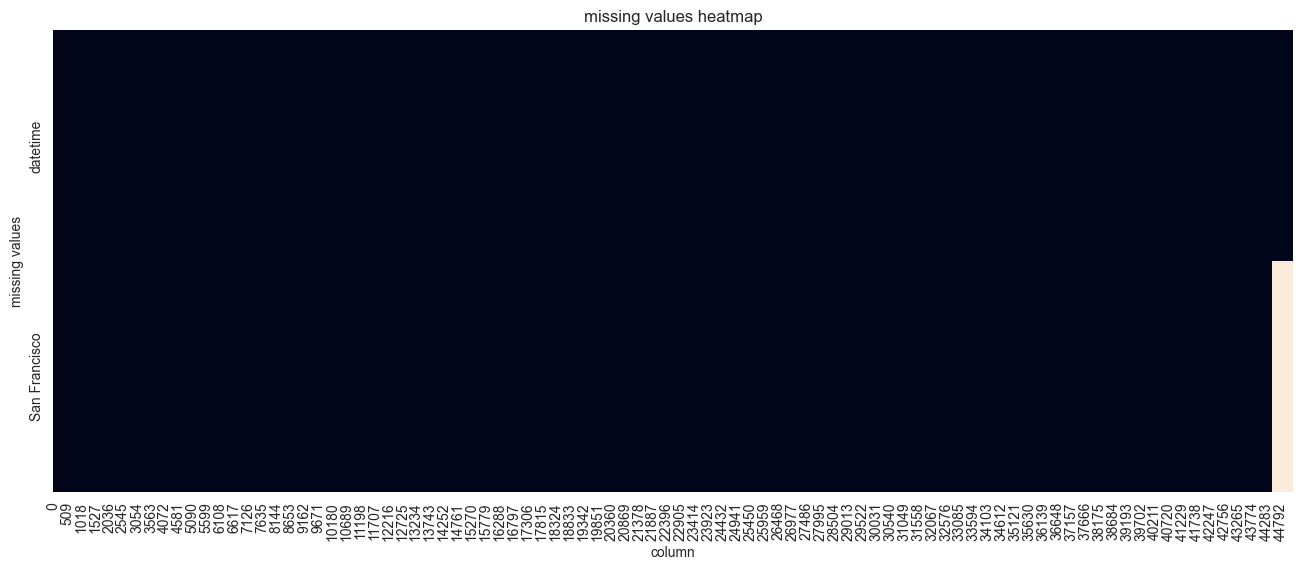

In [75]:
fig, ax = plt.subplots(figsize=(16,6))
sns.heatmap(tdf_sf.isna().transpose(), cbar=False, ax=ax)
plt.title("missing values heatmap", fontsize=12)
plt.xlabel("column", fontsize=10) 
plt.ylabel("missing values", fontsize=10)
plt.show()

In [76]:
print("Persentase data yang missing")
print(100*(tdf_sf.isnull().sum())/len(tdf_sf))

Persentase data yang missing
datetime         0.00000
San Francisco    1.75237
dtype: float64


Terlihat pada missing values heatmap bahwa terdapat nilai-nilai kosong pada record-record terakhir di dataset. Pola dari nilai-nilai kosong tersebut pula terlihat tidak tersebar sehingga dapat disimpulkan bahwa ekstraksi data oleh pemilik dataset hanya mengalami kegagalan pada waktu-waktu terakhir. Dalam kata lain, proses ekstraksi data tidak mengalami kegagalan intermiten yang memerlukan suatu strategi imputasi data; menghapus baris-baris yang kosong saja sudah cukup. Penghapusan baris-baris yang kosong pula tidak akan berdampak buruk pada kelengkapan data karena data kosong hanya 1,75% dari keseluruhan data. 

Namun, terlihat pada head atau 5 indeks pertama dari dataframe suhu (`tdf_sf`) bahwa indeks pertama kosong. Kekosongan ini dapat diisi dengan menggunakan nilai nilai pada indeks kedua atau pada jam berikutnya. Hal ini dapat diterapkan karena suhu udara tidak mengalami fluktuasi yang tajam dari jam ke jam, terlebih untuk lokasi-lokasi di luar lingkar kutub, sehingga mengestimasi nilai sebelumnya dengan nilai pada jam berikutnya sudah cukup.

In [77]:
tdf_sf = tdf_sf.bfill(limit=1)
tdf_sf.head()

,datetime,San Francisco
0,2012-10-01 12:00:00,289.480000
1,2012-10-01 13:00:00,289.480000
2,2012-10-01 14:00:00,289.474993
3,2012-10-01 15:00:00,289.460618
4,2012-10-01 16:00:00,289.446243


Timezone yang digunakan oleh pemilik dataset adalah GMT+3 seperti observasi oleh seorang pengguna pada forum diskusi ini: https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data/discussion/56294. Observasi ini didasari dari melihat tinggi rendahnya suhu pada setiap jam. Pengguna tersebut mengasumsikan timezone adalah GMT+3 (Israel). Asumsi ini dianggap benar karena pemilik dataset juga mengekstrak data suhu untuk kota-kota di Israel dan suhu pada setiap jam untuk kota-kota tersebut sesuai. Maka, kolom datetime pada dataset tersebut perlu diundur selama 10 jam (San Francisco berada di GMT-7).

Catatan: pengunduran kolom dataset tidak mengakomodir Daylight Saving Time

In [78]:
# Konversi dari Kelvin menjadi Celcius
tdf_sf_c = tdf_sf['San Francisco'].apply(lambda x: x - 273.15)

# Konversi datetime menjadi format yang sama dengan datetime Open-meteo (untuk memudahkan enriching nantinya)
tdf_sf_dt_om = pd.to_datetime(tdf_sf['datetime'])

source_tz = 'Etc/GMT-3'
tdf_sf_dt_om = tdf_sf_dt_om.dt.tz_localize(source_tz)

target_tz = 'Etc/GMT+7'
tdf_sf_dt_om = tdf_sf_dt_om.dt.tz_convert(target_tz)

new_om = []
for dt in tdf_sf_dt_om:
    temp = str(dt).split(' ')
    temp_time = temp[1].split('-')
    act_time = temp_time[0].split(':')
    new_time = ':'.join((act_time[0], act_time[1]))
    res = 'T'.join((temp[0], new_time))
    new_om.append(res)

tdf_sf_in_c = pd.DataFrame(data={
    'datetime': new_om,
    'San Francisco': tdf_sf_c
})

tdf_sf_in_c.head()

,datetime,San Francisco
0,2012-10-01T02:00,16.330000
1,2012-10-01T03:00,16.330000
2,2012-10-01T04:00,16.324993
3,2012-10-01T05:00,16.310618
4,2012-10-01T06:00,16.296243


In [79]:
tdf_sf_in_c = tdf_sf_in_c.dropna()
tdf_sf_in_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44461 entries, 0 to 44460
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   datetime       44461 non-null  object 
 1   San Francisco  44461 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.0+ MB


In [80]:
tdf_sf_in_c.iloc[-1]

datetime         2017-10-27T14:00
San Francisco               28.92
Name: 44460, dtype: object

### Enriching

Data pada dataset yang didapatkan dari kaggle hanya diekstraksi sampai tanggal 27 Oktober 2017 pukul 14:00. Menurut pemilik dataset, ekstraksi dilakukan menggunakan API dari OpenWeather. Namun, akses API dari OpenWeather untuk data historis berbayar, sehingga kami memutuskan untuk menggunakan API dari Open-meteo (https://open-meteo.com/en/docs/historical-weather-api) untuk melengkapi dataset ini sampai tanggal 1 Mei 2025.

Akses API Open-meteo gratis dan dapat langsung mengunduh data dalam format .csv. Link yang kami gunakan untuk mendapatkan data historis sbb.

```
https://archive-api.open-meteo.com/v1/archive?latitude=37.77&longitude=-122.41&start_date=2017-10-27&end_date=2025-05-01&hourly=temperature_2m&timezone=auto
```

In [6]:
url = "https://archive-api.open-meteo.com/v1/archive?latitude=37.77&longitude=-122.41&start_date=2017-10-27&end_date=2025-05-01&hourly=temperature_2m&timezone=auto"

In [24]:
res = requests.get(url)

In [30]:
if res.status_code == 200:
    data = res.json()
    df = pd.DataFrame(data={'datetime': data['hourly']['time'], 'San Francisco': data['hourly']['temperature_2m']})
    df.head()
else:
    print(res.status_code)

df.head()

,datetime,San Francisco
0,2017-10-27T00:00,17.3
1,2017-10-27T01:00,18.8
2,2017-10-27T02:00,18.1
3,2017-10-27T03:00,17.5
4,2017-10-27T04:00,17.2


In [81]:
df.to_csv('../data/open-meteo-sf-temp2m-20171027-20250501.csv', index=False)

In [85]:
tdf_om_sf = pd.read_csv('../data/open-meteo-sf-temp2m-20171027-20250501.csv')
tdf_om_sf.head()

,datetime,San Francisco
0,2017-10-27T00:00,17.3
1,2017-10-27T01:00,18.8
2,2017-10-27T02:00,18.1
3,2017-10-27T03:00,17.5
4,2017-10-27T04:00,17.2


In [86]:
tdf_om_sf_clean = pd.DataFrame(tdf_om_sf.iloc[15:,:2])
tdf_om_sf_clean = tdf_om_sf_clean.reset_index()
tdf_om_sf_clean = tdf_om_sf_clean.drop(columns=['index'])
tdf_om_sf_clean = tdf_om_sf_clean.rename(columns={'latitude': 'datetime', 'longitude': 'San Francisco'})
tdf_om_sf_clean = tdf_om_sf_clean.astype({'San Francisco': 'float64'})
tdf_om_sf_clean.head()

,datetime,San Francisco
0,2017-10-27T15:00,22.4
1,2017-10-27T16:00,19.8
2,2017-10-27T17:00,18.4
3,2017-10-27T18:00,17.8
4,2017-10-27T19:00,17.7


In [87]:
tdf_om_sf_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65841 entries, 0 to 65840
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   datetime       65841 non-null  object 
 1   San Francisco  65841 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.0+ MB


In [115]:
enr_tdf_sf = pd.concat([tdf_sf_in_c, tdf_om_sf_clean], ignore_index=True)
enr_tdf_sf.head()

,datetime,San Francisco
0,2012-10-01T02:00,16.330000
1,2012-10-01T03:00,16.330000
2,2012-10-01T04:00,16.324993
3,2012-10-01T05:00,16.310618
4,2012-10-01T06:00,16.296243


In [114]:
enr_tdf_sf.iloc[-5:]

,datetime,San Francisco
110297,2025-05-01T19:00,12.3
110298,2025-05-01T20:00,11.5
110299,2025-05-01T21:00,11.2
110300,2025-05-01T22:00,11.1
110301,2025-05-01T23:00,11.1


In [89]:
enr_tdf_sf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110302 entries, 0 to 110301
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   datetime       110302 non-null  object 
 1   San Francisco  110302 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.7+ MB


### Validating

In [90]:
tdf_sf_in_c.describe()

,San Francisco
count,44461.000000
mean,15.005850
std,5.332806
min,-0.850000
25%,11.520000
50%,14.460000
75%,17.864667
max,40.470000


In [98]:
tdf_sf_in_c.iloc[-6:]

,datetime,San Francisco
44455,2017-10-27T09:00,21.90
44456,2017-10-27T10:00,23.91
44457,2017-10-27T11:00,25.99
44458,2017-10-27T12:00,27.41
44459,2017-10-27T13:00,27.91
44460,2017-10-27T14:00,28.92


In [97]:
tdf_om_sf_clean.head()

,datetime,San Francisco
0,2017-10-27T15:00,22.4
1,2017-10-27T16:00,19.8
2,2017-10-27T17:00,18.4
3,2017-10-27T18:00,17.8
4,2017-10-27T19:00,17.7


In [92]:
tdf_om_sf_clean.describe()

,San Francisco
count,65841.000000
mean,13.401104
std,3.489584
min,2.900000
25%,11.000000
50%,13.300000
75%,15.500000
max,37.900000


In [93]:
tdf_om_sf_clean.iloc[-1]

datetime         2025-05-01T23:00
San Francisco                11.1
Name: 65840, dtype: object

Terdapat perbedaan suhu sebesar 6 derajat celcius dari 27 Oktober 2017 pukul 14:00 ke 15:00. Hal ini dapat disebabkan oleh kedua sumber API menggunakan pembacaan suhu dari stasiun cuaca yang berbeda atau dengan alat yang berbeda walaupun ditetapkan pada koordinat yang sama. Tetapi, dari persebaran data terlihat bahwa tiap kuartil tidak berbeda jauh satu sama lain, sehingga walaupun pembacaan suhu mungkin dilakukan dengan alat yang berbeda, data akan masih konsisten. Selain itu, perubahan drastis tersebut berkemungkinan kecil berdampak pada tahap pemodelan karena hanya merupakan satu kasus tertentu dibanding suatu kejadian yang berulang. 

Untuk mempermudah insertion ke database, kolom `datetime` diubah menjadi format `YYYY-MM-DD HH-MM-SS+/-TZ`, misalnya `2025-01-01 14:00:00-07`. Hal ini tidak dilakukan di awal karena bisa saja sumber data yang berbeda menggunakan format timestamp yang berbeda pula. Perubahan yang dilakukan sebelumnya hanya untuk memungkinkan data disimpan dalam bentuk .csv untuk mempermudah pengerjaan.

In [131]:
enr_tdf_sf_sqltz = enr_tdf_sf.copy()

In [132]:
for i, dt in enumerate(enr_tdf_sf_sqltz['datetime']):
    temp = dt.split('T')
    postfix = ':00-07'
    temp_time = temp[1] + postfix
    res = ' '.join((temp[0], temp_time))
    enr_tdf_sf_sqltz.iloc[i, 0] = res

In [156]:
enr_tdf_sf_sqltz.head()

,datetime,San Francisco
0,2012-10-01 02:00:00-07,16.330000
1,2012-10-01 03:00:00-07,16.330000
2,2012-10-01 04:00:00-07,16.324993
3,2012-10-01 05:00:00-07,16.310618
4,2012-10-01 06:00:00-07,16.296243


In [157]:
enr_tdf_sf_sqltz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110302 entries, 0 to 110301
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   datetime       110302 non-null  object 
 1   San Francisco  110302 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.7+ MB


## Load ke target

### Publishing

In [99]:
# Save local
enr_tdf_sf.to_csv('../data/historial-hourly-temp-sf-2012-2025.csv')

In [100]:
# Save ke PostgreSQL di remote server (10.34.100.114)
import psycopg2

In [137]:
try:
    conn = psycopg2.connect(database="proyekakhir",
                        host="10.34.100.114",
                        user="postgres",
                        password="SKTgroup1new",
                        port="5432")
    cursor = conn.cursor()
except Exception as e:
    print(e)

In [158]:
errs = []
insert_query = "INSERT INTO sf_temp (datetime, temperature) VALUES (%s, %s);"

for index, row in enr_tdf_sf_sqltz.iterrows():
    values = (str(row['datetime']), str(row['San Francisco']))

    try:
        cursor.execute(insert_query, values)
    except Exception as e:
        errs.append(e)

    conn.commit()

print(errs)
print(len(errs))

[UniqueViolation('duplicate key value violates unique constraint "sf_temp_pkey"\nDETAIL:  Key (datetime)=(2012-10-01 09:00:00+00) already exists.\n'), UniqueViolation('duplicate key value violates unique constraint "sf_temp_pkey"\nDETAIL:  Key (datetime)=(2012-10-01 10:00:00+00) already exists.\n'), UniqueViolation('duplicate key value violates unique constraint "sf_temp_pkey"\nDETAIL:  Key (datetime)=(2012-10-01 11:00:00+00) already exists.\n'), UniqueViolation('duplicate key value violates unique constraint "sf_temp_pkey"\nDETAIL:  Key (datetime)=(2012-10-01 12:00:00+00) already exists.\n'), UniqueViolation('duplicate key value violates unique constraint "sf_temp_pkey"\nDETAIL:  Key (datetime)=(2012-10-01 13:00:00+00) already exists.\n'), UniqueViolation('duplicate key value violates unique constraint "sf_temp_pkey"\nDETAIL:  Key (datetime)=(2012-10-01 14:00:00+00) already exists.\n'), UniqueViolation('duplicate key value violates unique constraint "sf_temp_pkey"\nDETAIL:  Key (datet

In [159]:
conn.close()